In [2]:
import numpy as np
import pandas as pd
from scipy.special import zeta
from scipy.special import roots_legendre
from scipy.special import roots_jacobi
from scipy.special import roots_laguerre
from scipy.special import factorial
from aq_python.polylog import  polylog_integrand 
from aq_python.polylog import  polylog_wrapper 
from aq_python.adaptive_quadrature import  AdaptiveGaussTree
from aq_python.adaptive_gauss_batch import  AdaptiveGaussTreeBatch

# Quadrature with Singular Endpoints
There are two classes in aq_python.  The AdaptiveGaussTree intgrates a one dimensional function in which the endpoints have integrable singularites of the form $log^n(x)/x^\alpha$ where $-1<\alpha<=0$ AdaptiveGaussTreeBatch creates a batch of these integrals in which you can define a set of parameters an have the integral calculated for all of the parameter combinations.  Here, we use the  Borwein, Borwein & Girgensohn integral representation,
$$
\mathrm{Li}_{s+1}(z) = \frac{z}{s!} \int_0^1 \frac{\mathrm{ln}^s\left( \frac{1}{t}\right)}{1-tz}dt.
$$
We integrate this for $s$ values in the range $2 \le s \le 10$, and for values of $z$ covering the interesting range 
$-1 \le z \le 1$. Note that $\mathrm{Li}_{s}(1) = \zeta(s)$ is a good numerical check in the integral results.

The Batch Integration allows you to input metadata to be written to a json file that will contain the integral results.

There are two possible ways to instantiate a class.  The first is by giving the constuctor a configuration a test function and a configuration.  The defaults for the configuration are:
* the_func
* parameters=None
* file=None
* tol=1e-6
* min_depth=2
* max_depth=10
* n1=5
* n2=10
* a_singular=False
* b_singular=False
* roots_legendre_n1=None
* roots_laguerre_n1=None
* roots_legendre_n2=None
* roots_laguerre_n2=None
* name="Batch Quadrature"
* author=None, version="1.0"
* reference=None
* description=None
* update_log_message='Initial Batch Creation'
the_func is a function of a variable that can be integrated and of all of the parameters in the parameter set.  Generally you are going to want to use a lambda for this after you define your parameter set, as follows:


In [ ]:
params = {"s": [z for z in range(2,11)], "z":  [x/10  for x in range(-10, 11)]}
the_func=lambda params, t: polylog_integrand(params["s"], params["z"], t)

Now we specify the metadata for the json.  I hope that the following example is illustrative of the intended use here:

In [ ]:
name_of_run = "Polylogs"
the_reference='hep-thXXXXX'
the_author='C. Glosser'
the_version="1.0"
the_description='''
Polylogs: Li_s(z), s:2-10, -1<z<1 for 20 pts.
Uses the Borwein, Borwein & Girgensohn integral representation. 
Since we have log^n(x) we use transformed endpoints and 
Gauss-Laguerre quadrature at 0.
'''

Now we call the constructor with our parameterization.  The constructor automatically generates a binary tree for each possible cobination of the parameters.

In [40]:
ad_tree = AdaptiveGaussTreeBatch( the_func, 
        params, 
        tol=1e-14, 
        min_depth=3, 
        max_depth=14, 
        n1=40, 
        n2=100, 
        a_singular=True, 
        b_singular=False, 
        name=name_of_run, 
        author=the_author, 
        version=the_version,
        reference=the_reference, 
        description=the_description)

The save_to_json method writes then trees for each of the regression to a json file.  By default it will not overwrite an existing file. You can turn that off by setting prevent_overwrite to False

In [4]:
#ad_tree.print_trees( nested_dict=None, level=0)
ad_tree.save_to_json('model_json/polylogs.json')

Error: model_json/polylogs.json exists. If you wish to overwrite the file, set prevent_overwrite=False


In [5]:
ad_tree.save_to_json('model_json/polylogs.json', prevent_overwrite=False)

The log can be manually updated using the add_update_log() member function. You can also add a message when loading an existing configuration, like we are doing here (this loads the integral we just calculate using the json file rather than recalcuating everything).

In [6]:
new_tree= AdaptiveGaussTreeBatch(the_func, file = 'model_json/polylogs.json',  update_log_message='making some changes')

As you can see the log has been updated in our instance.  If we save the json again the updates will appear with an new log entry

In [7]:
new_tree.update_log

[{'timestamp': '2025-02-07T14:20:12.692983',
  'message': 'Initial Batch Creation'},
 {'timestamp': '2025-02-07T14:20:12.917903', 'message': 'making some changes'}]

If you have had a chance to look at the regressions, anbd you are happy with the results, then you can just save off the heads of the trees, and dump the regression parameters with "dump_roots " so that the unnessary info isn't taking up unneeded space.

In [24]:
new_tree.save_to_json('model_json/polylogs_no_tree.json', prevent_overwrite=False, write_trees=False, dump_roots=True)

If you ewant to do some analysis with the reults, the Python version dumps the tree into a DataFrame

In [70]:
df = new_tree.to_dataframe()
df.head()

,s,z,a,b,depth,tol,error,integral,method
0,2,-1.0,0,1,0,1.000000e-14,0.0,-0.822467,Gauss-Laguerre
1,2,-0.9,0,1,0,1.000000e-14,0.0,-0.752163,Gauss-Laguerre
2,2,-0.8,0,1,0,1.000000e-14,0.0,-0.679782,Gauss-Laguerre
3,2,-0.7,0,1,0,1.000000e-14,0.0,-0.605158,Gauss-Laguerre
4,2,-0.6,0,1,0,1.000000e-14,0.0,-0.528107,Gauss-Laguerre


Now we can plot so dilogs and see how we did!

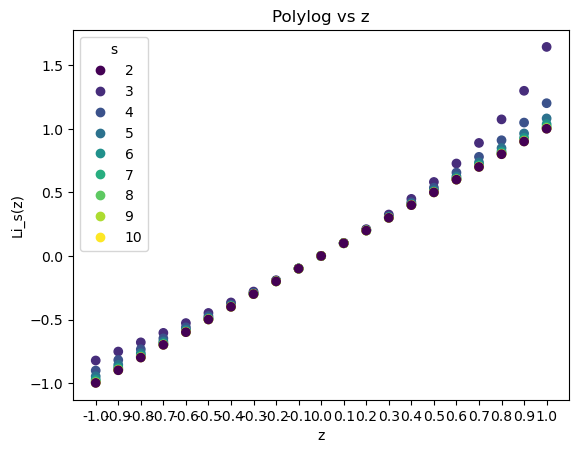

In [11]:

import matplotlib.pyplot as plt
# Create the scatter plot
fig, ax = plt.subplots()
scatter = ax.scatter(df['z'], df['integral'], c=df['s'].astype('category').cat.codes, cmap='viridis')

# Create the legend
handles, labels = scatter.legend_elements(prop="colors")
ax.legend(handles, df['s'].unique(), title="s")

# Add labels and title
plt.xlabel('z')
plt.ylabel('Li_s(z)')
plt.title('Polylog vs z')

# Show the plot
plt.show()
